# 作业3：深度学习框架实践

本次作业将练习深度学习框架的使用，大部分内容用 PyTorch 实现。第1题利用卷积层和全连接层实现手写数字的识别，第2题利用 RNN 来实现英文名的自动生成，第3题是算法题，利用卷积运算实现任意大整数的乘法。

### 第1题

1. 目标：通过对 MNIST 数据进行训练，构建一个简单的图像分类模型，对图片中的数字进行识别。你将利用该模型对自己真实手写出的数字进行预测，观察模型效果。

2. 主要步骤：获取数据，创建模型结构，定义损失函数，编写训练循环，实施预测。

3. 获取数据。我们使用知名的 MNIST 数据集，它可以从 PyTorch 中利用工具函数下载得到。原始的 MNIST 数据训练集大小为60000，我们随机抽取其中的10000个观测进行简单的训练。以下函数会在当前目录建立一个名为 data 的文件夹，其中会包含下载得到的数据集。

**注意：请在任何程序的最开始加上随机数种子的设置。请保持这一习惯。**

In [ ]:
# 查看gpu/tpu信息
import tensorflow as tf
tf.test.gpu_device_name()
!/opt/bin/nvidia-smi
# 安装环境
!pip install pytorch-lightning
!pip install numpy
!pip install pandas
!pip install torch torchvision
!pip install minetorch
!pip install matplotlib
!pip install scipy
!pip install scikit-learn
!pip install seaborn
!pip install category_encoders
!pip install optuna


# 载入driver数据
from google.colab import drive
drive.mount('/content/drive')
!mkdir ./data
!cp /content/drive/MyDrive/ai2021s/HW3.zip ./data/
!cd ./data && unzip HW3.zip
!cp /content/drive/MyDrive/ai2021s/digits.zip ./data/
!cd ./data && unzip digits.zip

# script
!mkdir ./src
!cp /content/drive/My\ Drive/src/utils.py ./src

In [153]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

np.random.seed(123)
torch.manual_seed(123)

mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
loader = DataLoader(mnist, batch_size=10000, shuffle=True)

我们一次性取出随机抽取到的10000个观测，其中 x 是图片数据，y 是图片对应的数字。

In [154]:
x, y = next(iter(loader))

一个习惯性动作是查看数据的大小和维度。

In [155]:
print(x.shape)
print(y.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


我们可以利用下面的函数展示图片的内容。如选择第一张图片，先将其转换成 Numpy 数组，再绘制图形：

(28, 28)


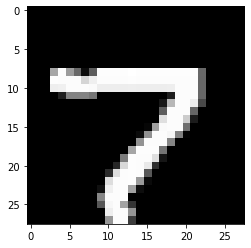

In [156]:
import matplotlib.pyplot as plt

img = x[0].squeeze().cpu().numpy()
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

接下来请你选择5个你喜欢的数字（10000以下），然后取出对应位置的图片，并画出它们的内容。

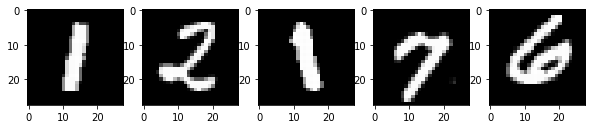

In [157]:
# Plot five digits here
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for s, i in enumerate([10, 50, 100, 1000, 5000]):
    img = x[i].squeeze().cpu().numpy()
    # print(img.shape)
    axes[s].imshow(img, cmap="gray")

4. 搭建模型。我们搭建一个类似于 LeNet-5 的网络，结构如下：

![](https://pic1.zhimg.com/80/v2-82eabb4c17e90d467197d013f7629f3c_720w.jpg)

我们需要创建2个卷积层、2个汇聚层（池化层）和2个全连接层，**暂时忽略所有的激活函数**。所有隐藏层的函数细节都可以在[官方文档](https://pytorch.org/docs/stable/nn.html)中按分类找到。每一个隐藏层本质上都是将一个数组变换成另一个数组的函数，因此为了确认编写的模型是正确的，可以先用一个小数据进行测试，观察输入和输出的维度。例如，我们先取出前10个观测，此时输入的维度是 `[10, 1, 28, 28]`：

In [158]:
smallx = x[0:20]
smally = y[0:20]
print(smallx.shape)
print(smally.shape)

torch.Size([20, 1, 28, 28])
torch.Size([20])


接下来创建第1个卷积层，并测试输出的维度。注意到我们可以直接将隐藏层当成一个函数来调用。

In [159]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
res = conv1(smallx)
print(res.shape)

torch.Size([20, 20, 24, 24])


可以看到，输出的维度为 `[20, 24, 24]`（不包括第1位的数据批次维度），与之前图中的结果吻合。

接下来，请按照图中提示编写层对象 `pool1`、`conv2`、`pool2`、`fc1` 和 `fc2`，并顺次测试输入与输出的维度，使其与上图匹配。注意，在将一个大小为 `[10, 50, 4, 4]` 的数组（假设叫 `somearray`）传递给 `fc1` 之前，需要先将其变形为只有两个维度的数组，做法是 `somearray.view(-1, 50*4*4)`，其中 -1 表示该位置的大小不变。

```py
pool1 = ...
res = pool1(res)
print(res.shape)

conv2 = ...
res = conv2(res)
print(res.shape)

pool2 = ...
res = pool2(res)
print(res.shape)

fc1 = ...
res = fc1(res.view(-1, 50 * 4 * 4))
print(res.shape)

fc2 = ...
res = fc2(res)
print(res.shape)
```

In [160]:
pool1 = torch.nn.MaxPool2d(2, stride=2)
res = pool1(res)
print(res.shape)

conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
res = conv2(res)
print(res.shape)

pool2 = torch.nn.MaxPool2d(2, stride=2)
res = pool2(res)
print(res.shape)

fc1 = torch.nn.Linear(50*4*4, 500)
res = fc1(res.view(-1, 50*4*4))
print(res.shape)

fc2 = torch.nn.Linear(500, 10)
res = fc2(res)
print(res.shape)

torch.Size([20, 20, 12, 12])
torch.Size([20, 50, 8, 8])
torch.Size([20, 50, 4, 4])
torch.Size([20, 500])
torch.Size([20, 10])


5. 创建模型类。在确保隐藏层维度都正确后，将所有的隐藏层封装到一个模型类中，其中模型结构在 `__init__()` 中定义，具体的计算过程在 `forward()` 中实现。此时需要加入激活函数。在本模型中，**请在 `conv1`、`conv2` 和 `fc1` 后加入 ReLU 激活函数，并在 `fc2` 后加入 Softmax 激活函数**。

```py
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ...
        self.pool1 = ...
        self.conv2 = ...
        self.pool2 = ...
        self.fc1 = ...
        self.fc2 = ...

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        ...
        return x
```

In [161]:
# pool1 = torch.nn.MaxPool2d(2, stride=2)
# res = pool1(res)
# print(res.shape)

# conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
# res = conv2(res)
# print(res.shape)

# pool2 = torch.nn.MaxPool2d(2, stride=2)
# res = pool2(res)
# print(res.shape)

# fc1 = torch.nn.Linear(50*4*4, 500)
# res = fc1(res.view(-1, 50*4*4))
# print(res.shape)

# fc2 = torch.nn.Linear(500, 10)
# res = fc2(res)
# print(res.shape)

In [162]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1),
            torch.nn.MaxPool2d(2, stride=2),
            torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1),
            torch.nn.MaxPool2d(2, stride=2)
        )
        self.fc_layer = torch.nn.Sequential(
            torch.nn.Linear(50*4*4, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        res = self.conv_layer(x)
        res = self.fc_layer(res.view(-1, 50*4*4))
        return res

再次测试输入输出的维度是否正确。如果模型编写正确，输出的维度应该是 `[10, 10]`，且输出结果为0到1之间的概率值。

In [163]:
np.random.seed(123)
torch.manual_seed(123)

model = LeNet()
pred = model(smallx)
print(pred.shape)
print(pred)

torch.Size([20, 10])
tensor([[0.0983, 0.0986, 0.1023, 0.1098, 0.0926, 0.0923, 0.0969, 0.1010, 0.1043,
         0.1039],
        [0.0996, 0.1023, 0.0976, 0.1066, 0.0946, 0.0890, 0.0958, 0.1051, 0.1025,
         0.1070],
        [0.0997, 0.0979, 0.0971, 0.1058, 0.0933, 0.0881, 0.0978, 0.1134, 0.1042,
         0.1028],
        [0.0929, 0.1025, 0.1000, 0.1054, 0.0936, 0.0893, 0.0970, 0.1091, 0.1040,
         0.1061],
        [0.1037, 0.0976, 0.0995, 0.1093, 0.0941, 0.0887, 0.0962, 0.1023, 0.1019,
         0.1067],
        [0.0986, 0.1010, 0.1008, 0.1058, 0.0928, 0.0903, 0.0994, 0.1036, 0.1047,
         0.1031],
        [0.0996, 0.1002, 0.0986, 0.1065, 0.0945, 0.0905, 0.0986, 0.1073, 0.1026,
         0.1017],
        [0.1000, 0.0982, 0.1017, 0.1068, 0.0880, 0.0893, 0.0977, 0.1059, 0.1043,
         0.1082],
        [0.0982, 0.0990, 0.1030, 0.1089, 0.0950, 0.0910, 0.0997, 0.0991, 0.1029,
         0.1031],
        [0.0980, 0.1019, 0.0990, 0.1056, 0.0958, 0.0878, 0.0963, 0.1087, 0.1022,
       

In [164]:
pred.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SumBackward1>)

`pred` 的每一行加总为1，其中每一个元素代表对应类别的预测概率。

我们还可以直接打印模型对象，观察隐藏层的结构：

In [165]:
print(model)

LeNet(
  (conv_layer): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


6. 损失函数。对于分类问题，损失函数通常选取为负对数似然函数。在 PyTorch 中，可以使用 `torch.nn.NLLLoss` 来完成计算。其用法是先定义一个损失函数对象，然后在预测值和真实标签上调用该函数对象。注意：损失函数对象的第一个参数是预测概率的**对数值**，第二个参数是真实的标签。[文档说明](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)。

In [166]:
lossfn = torch.nn.NLLLoss()
lossfn(torch.log(pred), smally)

tensor(2.3278, grad_fn=<NllLossBackward>)

7. 利用课上介绍的循环模板和代码示例，对模型进行迭代训练。对于本数据，选取 mini-batch 大小为200，共遍历数据10遍，优化器选为 Adam，学习率为0.001。

In [167]:
nepoch = 10
batch_size = 200

model = LeNet()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

n = x.shape[0]
obs_id = np.arange(n)  # [0, 1, ..., n-1]
# Run the whole data set `nepoch` times
for i in range(nepoch):
    # Shuffle observation IDs
    np.random.shuffle(obs_id)

    # Update on mini-batches
    for j in range(0, n, batch_size):
        # Create mini-batch
        x_mini_batch = x[obs_id[j:(j + batch_size)]]
        y_mini_batch = y[obs_id[j:(j + batch_size)]]
        # Compute loss
        pred = model(x_mini_batch)
        lossfn = torch.nn.NLLLoss()
        loss = lossfn(torch.log(pred), y_mini_batch)
        # Compute gradient and update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (j // batch_size) % 10 == 0:
            print(f"epoch {i}, batch {j // batch_size}, loss = {loss.item()}")

epoch 0, batch 0, loss = 2.2982962131500244
epoch 0, batch 10, loss = 2.1863176822662354
epoch 0, batch 20, loss = 2.0785770416259766
epoch 0, batch 30, loss = 1.9274557828903198
epoch 0, batch 40, loss = 1.6302570104599
epoch 1, batch 0, loss = 1.3760998249053955
epoch 1, batch 10, loss = 1.1694927215576172
epoch 1, batch 20, loss = 0.8895391225814819
epoch 1, batch 30, loss = 0.80918288230896
epoch 1, batch 40, loss = 0.6207155585289001
epoch 2, batch 0, loss = 0.6358242630958557
epoch 2, batch 10, loss = 0.47683170437812805
epoch 2, batch 20, loss = 0.5217666625976562
epoch 2, batch 30, loss = 0.4376486837863922
epoch 2, batch 40, loss = 0.41190648078918457
epoch 3, batch 0, loss = 0.37967923283576965
epoch 3, batch 10, loss = 0.4022546708583832
epoch 3, batch 20, loss = 0.3303138017654419
epoch 3, batch 30, loss = 0.45458054542541504
epoch 3, batch 40, loss = 0.3156256079673767
epoch 4, batch 0, loss = 0.372991681098938
epoch 4, batch 10, loss = 0.3252071142196655
epoch 4, batch 20

为了验证模型的效果，我们对前10个观测（即之前生成的 `smallx` 和 `smally`）进行预测。

In [168]:
ypred = model(smallx)
print(np.round(ypred.detach().cpu().numpy(), 3))
print(smally)

[[0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.955 0.    0.    0.009 0.    0.036]
 [0.    0.    0.    0.003 0.    0.996 0.    0.    0.    0.   ]
 [0.    0.    0.006 0.    0.978 0.    0.005 0.001 0.    0.01 ]
 [0.998 0.    0.    0.    0.    0.002 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.001 0.    0.    0.879 0.001 0.118]
 [0.    0.986 0.004 0.001 0.001 0.001 0.    0.004 0.004 0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.998 0.    0.002]
 [0.    0.    0.    0.    0.982 0.    0.    0.001 0.    0.018]
 [0.    0.983 0.001 0.    0.    0.    0.004 0.    0.011 0.   ]
 [0.    0.    0.    0.    0.996 0.    0.    0.    0.    0.004]
 [0.    0.    0.939 0.059 0.    0.001 0.001 0.    0.    0.   ]
 [0.    0.999 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.995 0.    0.    0.001 0.    0.004]
 [0.    0.    0.    0.    0.    0.    0.998 0.    0.002

如果模型搭建和训练都正常，那么每一行中概率最大的取值所在的位置应该正好对应真实的标签。

最后，我们用模型对一些真实的手写数字图片进行预测。请你利用绘图软件（如 Windows 自带的绘图，或 Photoshop 等）准备10张正方形黑色底色的图片，每张用鼠标绘制一个数字（请使用较粗的笔划），从0到9，然后以0.png，1.png等文件名存储下来，放到当前目录一个名为 digits 的文件夹中。以下是几个例子：
![](digits/sample0.png) ![](digits/sample5.png) ![](digits/sample8.png)

接下来利用 Pillow 软件包读取图片：

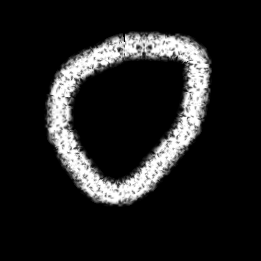

In [169]:
from PIL import Image
im = Image.open("/content/data/HW3/digits/sample0.png")
im

此时如果直接将其转为 Numpy 数组会得到三个通道：

In [170]:
im_arr = np.array(im)
print(im_arr.shape)

(261, 261, 3)


因此，我们先强制转换为灰度图片（单通道），再缩放至模型的图片大小 28 x 28：

In [171]:
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
print(im_arr.shape)
im

(28, 28)


为了传递给模型对象，还需要先将数值归一化到 [0,1] 区间，转换为 PyTorch 的 Tensor 类型，并增加一个批次和一个通道的维度：

In [172]:
test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
print(test0.shape)

torch.Size([1, 1, 28, 28])


最后对图片标签进行预测：

In [173]:
pred0 = model(test0)
print(np.round(pred0.detach().cpu().numpy(), 3))

[[0.468 0.    0.259 0.002 0.038 0.017 0.167 0.009 0.009 0.03 ]]


预测结果是否符合真实情形？请对你自己绘制出的10张图片进行类似的预测操作，并评价其效果。

In [176]:
for i in range(10):
    im = Image.open("/content/data/myDraw_%s.png" % i)
    im = im.convert("L")
    im.thumbnail((28, 28))
    im_arr = np.array(im)
    test = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
    pred = model(test)[0].detach().cpu().numpy()
    print("数字%s的预测为: %s" % (i, pred.argmax()))

数字0的预测为: 0
数字1的预测为: 1
数字2的预测为: 4
数字3的预测为: 3
数字4的预测为: 4
数字5的预测为: 5
数字6的预测为: 6
数字7的预测为: 7
数字8的预测为: 8
数字9的预测为: 9


可以看到，仅数字2错误预测为4，预测准确度在该小样本上达到90%

### 第2题

1. 目标：通过对英文名数据进行训练，构建一个 RNN 模型，实现英文名的自动生成。

2. 主要步骤：获取和整理数据，对字符串进行 one-hot 编码，创建模型结构，定义损失函数，编写训练循环，最后生成人名字符串。

3. 获取和整理数据。数据文件已存为 `data/names.txt`，先将其读取为字符串列表：

In [29]:
import io
lines = io.open("/content/data/HW3/data/names.txt").read().strip().split('\n')
print(len(lines))
print(lines[0:5])

3668
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


可以看出，共读取了3668个名字。为了简单起见，我们将所有的大写字母转换为小写。

In [30]:
names = [s.lower() for s in lines]
print(names[0:5])

['abbas', 'abbey', 'abbott', 'abdi', 'abel']


接下来我们需要构建一个字符的字典。对于英文名来说很简单，即26个字母。我们可以通过下面的代码直接得到。

In [31]:
import string
dict = string.ascii_lowercase
dict

'abcdefghijklmnopqrstuvwxyz'

4. 下面准备好 one-hot 编码所需的函数。编写函数 `char2index(char)`，将一个字母转换为其所在字典的位置。例如 `char2index("a")` 要返回0，`char2index("z")` 要返回25，等等。提示：使用字符串的 `.find()` 函数。

In [49]:
def char2index(char):
    # Implementation here
    return dict.find(char)

print(char2index("z") == 25)

True


编写 `char2tensor(char)` 函数，将一个字母转换为 one-hot 向量，即该向量中第 i 个元素为1，其余为0，其中 i 表示该字母在字典中的位置。

**注意，该向量的长度应为27，因为我们要预留终止符，用 `[0.0, 0.0, ..., 1.0]` 表示**。

`char2tensor("a")` 应返回 `torch.tensor([1.0, 0.0, ...])`，`char2tensor("z")` 应返回 `torch.tensor([0.0, ..., 1.0, 0.0])`。

In [81]:
def char2tensor(char):
    # ones = torch.sparse.torch.eye(27)
    # select = torch.tensor([char2index(x)+1 for x in char])
    # res = ones.index_select(0, select).sum(axis=0)
    res = torch.zeros((27,))
    res[char2index(char)] = 1
    return res

print(char2tensor("a"))
print(char2tensor("z"))
print(char2tensor("z").shape[0] == 27)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.])
True


5. 构建模型。我们使用最简单的 RNN 结构，即隐藏单元是输入和上一期隐藏单元的线性变换加上 Tanh 激活函数，输出单元是隐藏单元的线性变换加上 Softmax 激活函数。输出的结果代表下一个字符的概率分布。

```py
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = ...
        self.h2o = ...

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.nn.functional.softmax(self.h2o(hidden), dim=1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
```

In [82]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size+hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, 27)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.nn.functional.softmax(self.h2o(hidden), dim=1)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

我们做一个简单的测试。请在下面的代码中加入适当的语句，使得每次运行的结果不变。根据其输出结果，请问当前模型预测字符a的下一个字符是什么？为什么？

In [83]:
rnn = RNN(input_size=27, hidden_size=10)
input = char2tensor("a")
hidden = rnn.init_hidden()
output, hidden = rnn(input.view(1, 27), hidden)
print(output)

tensor([[0.0383, 0.0323, 0.0385, 0.0263, 0.0415, 0.0433, 0.0386, 0.0255, 0.0419,
         0.0336, 0.0325, 0.0368, 0.0449, 0.0319, 0.0451, 0.0417, 0.0359, 0.0413,
         0.0258, 0.0272, 0.0486, 0.0472, 0.0285, 0.0295, 0.0438, 0.0377, 0.0417]],
       grad_fn=<SoftmaxBackward>)


6. 接下来我们定义好损失函数。与第1题中类似，预测值是一个概率分布，而真实的标签是0到26中的一个整数，代表真实的下一个字符在字典中的位置。假设当前处理的名字为"abel"，那么字符a的输出结果对应的标签是什么？请完成下面的代码。

In [85]:
# Change "target" to a proper value
target = char2index("a")

lossfn = torch.nn.NLLLoss()
loss = lossfn(torch.log(output), torch.tensor([target]))
print(loss)

tensor(3.2634, grad_fn=<NllLossBackward>)


7. 明确单个字符的损失函数的计算方法后，请在下面计算出"abel"这个观测整体的损失函数值。

In [89]:
y = "abel"
loss = 0
nchar = len(y)
for i, alp in enumerate(y):
    input = char2tensor(alp)
    if i == 0:
        hidden = rnn.init_hidden()
    output, hidden = rnn(input.view(1, 27), hidden)
    if i == nchar - 1:
        target = 26
    else:
        target = char2index(y[i+1])
    loss += lossfn(torch.log(output), torch.tensor([target]))
loss = loss / nchar
print(loss)

tensor(2.3537, grad_fn=<DivBackward0>)


8. 将上述过程在数据上进行反复迭代，训练模型。

In [148]:
np.random.seed(123)
torch.random.manual_seed(123)

n = len(names)
n_hidden = 16
n_input = 27
nepoch = 10

rnn = RNN(n_input, n_hidden)
opt = torch.optim.Adam(rnn.parameters(), lr=0.0001)
train_ind = np.arange(n)
losses = []

lossfn = torch.nn.NLLLoss()

# Loop over epochs
for k in range(nepoch):
    # Shuffle the data
    np.random.shuffle(train_ind)
    # Loop over observations. Each observation is a name
    for i in range(n):
        name = names[train_ind[i]]
        nchar = len(name)
        # Loop over the characters in the name
        # Each input character has a target, which is the index of the next character in the dictionary
        # For the last character in the name, the target is the end-of-sequence symbol, which has index 26
        loss = 0.0
        hidden = rnn.init_hidden()
        for j in range(nchar):
            input = char2tensor(name[j])
            output, hidden = rnn(input.view(1, n_input), hidden)

            if j == nchar - 1:
                target = 26
            else:
                target = char2index(name[j+1])

            loss = loss + lossfn(torch.log(output), torch.tensor([target]))
    
        loss = loss / nchar

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if i % 1000 == 0:
            print(f"epoch {k}, obs {i}, loss = {loss.item()}")

epoch 0, obs 0, loss = 3.3991856575012207
epoch 0, obs 1000, loss = 2.918344020843506
epoch 0, obs 2000, loss = 2.6398532390594482
epoch 0, obs 3000, loss = 3.1096529960632324
epoch 1, obs 0, loss = 2.776276111602783
epoch 1, obs 1000, loss = 2.5617995262145996
epoch 1, obs 2000, loss = 2.4159867763519287
epoch 1, obs 3000, loss = 2.4527029991149902
epoch 2, obs 0, loss = 2.5975751876831055
epoch 2, obs 1000, loss = 2.585355520248413
epoch 2, obs 2000, loss = 2.5821337699890137
epoch 2, obs 3000, loss = 2.7673683166503906
epoch 3, obs 0, loss = 2.584155559539795
epoch 3, obs 1000, loss = 2.1915831565856934
epoch 3, obs 2000, loss = 2.4389891624450684
epoch 3, obs 3000, loss = 2.0150928497314453
epoch 4, obs 0, loss = 2.4576306343078613
epoch 4, obs 1000, loss = 2.912224769592285
epoch 4, obs 2000, loss = 2.5470447540283203
epoch 4, obs 3000, loss = 2.1251463890075684
epoch 5, obs 0, loss = 2.283302068710327
epoch 5, obs 1000, loss = 2.564319133758545
epoch 5, obs 2000, loss = 2.1136810

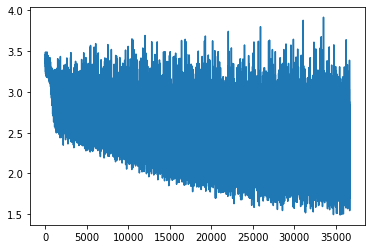

In [178]:
import matplotlib.pyplot as plt
plt.plot(losses)

9. 编写一个函数 `random_first_letter()`，它随机返回字典中的一个字符，我们将利用它来随机生成第一个字符。

In [179]:
def random_first_letter():
    return np.random.choice([a for a in dict])

print(random_first_letter())
print(random_first_letter())
print(random_first_letter())

z
m
g


请简要说明如下的代码的含义（可以在代码中加入注释），然后利用它随机生成10个名字。评价生成的结果，并简要说明可以如何改进模型的效果？

In [180]:
def random_name(max_len=20):
    rnn.eval()  # 抽离计算图，计算过程不更新梯度
    first_letter = random_first_letter()  # 随机生成第一个字符
    char_ind = [char2index(first_letter)]  # 用于保存生成的名字，并把首个字母加进去
    input = char2tensor(first_letter)  # 转化为tensor
    # print(input)
    hidden = rnn.init_hidden()  # 初始化隐藏层输出
    for i in range(max_len - 1):
        output, hidden = rnn(input.view(1, n_input), hidden)  # 循环计算
        # print(output)
        ind = torch.argmax(output).item()  # 把概率最高的取为输出值
        # print(ind)
        if ind == 26:  # 这里有修改，因为我定义0为未知字符
            break
        char_ind.append(ind)  # 加入下一个模型预测的字母
        input.zero_()  # 新的输入是上次输出的字符
        input[ind] = 1.0
        # print(input)
    return "".join([dict[i] for i in char_ind])  # 拼接并返回

可以看到，生成的名字长度适中，但是看起来并不是合理的名字(并且rlen结尾出现多次)，结合训练时损失函数的下降并不顺利，考虑是由于RNN难以训练导致的欠拟合；可以考虑换为GRU模型或者LSTM模型。

In [181]:
for i in range(10):
    print(random_name())

xarle
kerlen
oner
oner
oner
ine
nerlen
darlen
yar
marlen


### 第3题

利用卷积函数实现任意大整数的乘法。给定两个整数，如 183612 和 23333，用两个列表表达它们的序列：

In [122]:
n1 = [1, 8, 3, 6, 1, 2]
n2 = [2, 3, 3, 3, 3]

请编写一个函数 `integer_mult(n1, n2)`，返回 `n1 * n2` 对应的整数序列。注意不要直接调用乘法表达式（设想有两个非常大的整数，直接相乘可能会导致数值溢出）。

In [125]:
def str2list(n1):
    return [int(x) for x in n1]

In [126]:
from math import floor

In [140]:
def integer_mult(n1, n2):
    # Implementation here
    p, q = str2list(n1), str2list(n2)
    p.reverse()
    q.reverse()

    tmp_res = np.convolve(p, q)

    # 进位
    res = []
    add = 0
    for i, n_ in enumerate(tmp_res):
        n = n_ + add
        if n <= 9:
            res.append(n)
            add = 0
        else:
            res.append(n % 10)
            add = n // 10
    if add != 0:
        res.append(add)
    
    res.reverse()
    return res

res = integer_mult(n1, n2)
print(res == [4, 2, 8, 4, 2, 1, 8, 7, 9, 6])

True


思路：

1. 先实现多项式的乘法。例如，给定 $p(x)=1+2x+x^4$ 和 $q(x)=x+3x^2+5x^3$，计算 $r(x)=p(x)q(x)$。我们将 $p(x)$ 编码为 `p = [1, 2, 0, 0, 1]`，$q(x)$ 编码为 `q = [0, 1, 3, 5]`，请编写函数 `poly_mult(p, q)`，使得 `poly_mult(p, q) == [0, 1, 5, 11, 10, 1, 3, 5]`。

In [123]:
p = [1, 2, 0, 0, 1]
q = [0, 1, 3, 5]

def poly_mult(p, q):
    # Implementation here
    res = np.convolve(p, q)
    return res

print(poly_mult(p, q) == [0, 1, 5, 11, 10,  1, 3, 5])

[ True  True  True  True  True  True  True  True]


2. 对于任意的一个整数，将其看成是某个多项式在 $x=10$ 处的取值，如 $123 = p_1(10)$，$p_1(x)=3+2x+x^2$，$5310 = p_2(10)$，$p_2(x)=x+3x^2+5x^3$，注意需要适当将序列反序。因此，要计算 $123\times 5310$，相当于计算 $r(10)$ 的值，但为了避免直接进行乘法运算（防止溢出），可以先计算 $r(x)$ 的表达式（等价于其系数向量），然后建立起 $r(x)$ 的系数与 $r(10)$ 之间的联系（见如下第3点）。

3. 如果一个多项式 $r(x)$ 所有的系数都是0到9之间的整数，那么 $r(x)$ 和 $r(10)$ 的关系非常直接，比如若 $r(x)=1+2x+5x^2+3x^3$，则 $r(10)=3521$。但如果有系数超过10，就需要考虑进位的影响，比如 $r(x)=1+11x+2x^2$，$r(10)=311$。此时可以从 $r(x)$ 的第一项开始逐项进位，构造一个新的多项式 $r'(x)=1+x+3x^2$，满足 $r'(10)=r(10)$，且 $r'(x)$ 所有的系数都不超过10。 

4. 综合利用以上信息，完成本题的算法编写。并测试 23742389754298365 * 809723950 的结果。

In [141]:
n1 = "23742389754298365"
n2 = "809723950"

In [177]:
"".join([str(x) for x in integer_mult(n1, n2)])

'19224781614290001586341750'